This notebook contains the dataset construction based on the raw dataset from the Hospital Sírio Libanês (HSL) database available at FAPESP COVID-19 Data Sharing/BR (https://repositoriodatasharingfapesp.uspdigital.usp.br/ ). 

The notebook aim is to generate a label of nosocomial infection among patients with COVID-19. The infection will be verified through the results of tests related to FUNGI and BACTERIA.

In [1]:
# Last modification: 15/04/2024

In [2]:
#Libraries
import numpy as np
import pandas as pd
from pandas import DataFrame
import csv
from numpy import mean
from numpy import std
from numpy import correlate
from numpy.random import randn
from numpy.random import seed
import matplotlib.pyplot as plt
#plt.style.use('default')
#%matplotlib inline
import seaborn as sns
#import pandas_profiling
#from google.colab import files
import seaborn as sns
import warnings
import datetime as dt
from datetime import date
import os

In [3]:
!pip install 'openpyxl>=3.0.0'

Defaulting to user installation because normal site-packages is not writeable


  # 1.0 - DATE INTEGRATION





















## Datasets

In [4]:
# Checks the existence of the file and, if necessary, goes to the correct directory
verifica_arquivo = os.path.exists("Datasets")
if verifica_arquivo == False:
    %cd /home/filipe/Documentos/GitHub/HCAI_prediction

/home/filipe/Documentos/GitHub/HCAI_prediction


/home/filipe/.local/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
ls

DatasetConstruction/  Datasets/  LICENSE  mainNotebook.ipynb  README.md


In [6]:
# file "HSL_Pacientes_4.csv"
df_pacientes = pd.read_csv('Datasets/HSL_Pacientes_4.csv', sep='|')
print("df_pacientes...............: ", df_pacientes.shape)

# verificando a existência de valores duplicatos
df_pacientes = df_pacientes.drop_duplicates()
print("df_pacientes sem duplicatos: ", df_pacientes.shape, "\n")

# file "HSL_Exames_4.csv" 
df_exames = pd.read_csv('Datasets/HSL_Exames_4.csv', sep='|')
print("df_exames..................: ", df_exames.shape)

# duplicates removal
df_exames = df_exames.drop_duplicates()
print("df_exames sem duplicatos...: ", df_exames.shape, "\n")

# create Exame.Analito column
df_exames["Exame.Analito"] = df_exames["DE_EXAME"]+"."+df_exames["DE_ANALITO"]

# file "HSL_Desfechos_4.csv"
df_desfecho = pd.read_csv('Datasets/HSL_Desfechos_4.csv', sep='|')
print("df_desfecho................: ", df_desfecho.shape)

# duplicates removal
df_desfecho = df_desfecho.drop_duplicates()
print("df_desfecho em duplicatos..: ", df_desfecho.shape)

# add columns from the 'outcome' dataset in front of their respective patient id and service_id equal
df_sirio = df_exames.merge(df_desfecho, on = ["ID_PACIENTE", "ID_ATENDIMENTO"], how = "left")
print("\ndf_sirio...................: ", df_sirio.shape)

# Obtendo SEXO e Ano de nascimento da planilha HSL_PACIENTES
pacientes_2 = df_pacientes[['ID_PACIENTE','AA_NASCIMENTO','IC_SEXO']]

# Obtaining SEX and Year of birth from the HSL_PATIENTES worksheet
df_sirio = df_sirio.merge(pacientes_2, on=['ID_PACIENTE'], how='left')
print("Pacientes únicos...........: ", df_sirio["ID_PACIENTE"].nunique(), '\n')

# create Exame.Analito column
df_sirio["Exame.Analito"] = df_sirio["DE_EXAME"]+"."+df_sirio["DE_ANALITO"]

df_sirio.columns

df_pacientes...............:  (14673, 7)
df_pacientes sem duplicatos:  (14673, 7) 

df_exames..................:  (2952999, 9)
df_exames sem duplicatos...:  (2899573, 9) 

df_desfecho................:  (89937, 8)
df_desfecho em duplicatos..:  (89937, 8)

df_sirio...................:  (2899573, 16)
Pacientes únicos...........:  14673 



Index(['ID_PACIENTE', 'ID_ATENDIMENTO', 'DT_COLETA', 'DE_ORIGEM', 'DE_EXAME',
       'DE_ANALITO', 'DE_RESULTADO', 'CD_UNIDADE', 'DE_VALOR_REFERENCIA',
       'Exame.Analito', 'DT_ATENDIMENTO', 'DE_TIPO_ATENDIMENTO', 'ID_CLINICA',
       'DE_CLINICA', 'DT_DESFECHO', 'DE_DESFECHO', 'AA_NASCIMENTO', 'IC_SEXO'],
      dtype='object')

In [7]:
df_desfecho['DT_ATENDIMENTO']

0        26/02/2020
1        27/03/2021
2        18/01/2021
3        27/09/2020
4        13/03/2020
            ...    
89932    30/03/2020
89933    17/04/2021
89934    26/01/2021
89935    29/12/2020
89936    23/03/2021
Name: DT_ATENDIMENTO, Length: 89937, dtype: object

First patient input

In [8]:
df_desfecho['DT_ATENDIMENTO'] = pd.to_datetime(df_desfecho['DT_ATENDIMENTO'])

ls_atendimento = df_desfecho['DT_ATENDIMENTO']

ls_atendimento = ls_atendimento.sort_values()

ls_atendimento.min()

/tmp/ipykernel_8282/1327082131.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_desfecho['DT_ATENDIMENTO'] = pd.to_datetime(df_desfecho['DT_ATENDIMENTO'])


Timestamp('2020-02-26 00:00:00')

Last patient output

In [9]:
ls_desfecho = df_desfecho['DT_DESFECHO']

# Identificando os índices das linhas com DDMMAA
linhas_com_ddmmaa = ls_desfecho.loc[ls_desfecho == 'DDMMAA'].index

# Excluindo as linhas com DDMMAA
ls_desfecho = ls_desfecho.drop(linhas_com_ddmmaa)

# Imprimindo a série sem DDMMAA
ls_desfecho = pd.to_datetime(ls_desfecho)

ls_desfecho.sort_values()

ls_desfecho.max()

/tmp/ipykernel_8282/2555599839.py:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ls_desfecho = pd.to_datetime(ls_desfecho)


Timestamp('2021-06-15 00:00:00')

##  Patients outcome analyzing

In [10]:
df_desfecho['DE_DESFECHO'].value_counts()

DE_DESFECHO
Alta Administrativa                                                 66908
Alta médica melhorado                                               21702
Desistência do atendimento                                            401
Alta a pedido                                                         261
Alta médica Inalterado                                                227
Óbito após 48hs de internação sem necrópsia                           172
Alta médica curado                                                    129
Alta por abandono                                                      65
Óbito nas primeiras 48hs de internação sem necrópsia não agônico       27
Transferência Inter-Hospitalar Externa - Serviço de Ambulância         27
Assistência Domiciliar                                                 11
Transferência Inter-Hospitalar Externa - Transporte Próprio             4
Óbito nas primeiras 48hs de internação sem necrópsia agônico            2
Óbito após 48hs de interna

In [11]:
df_desfecho.head(3)

,ID_PACIENTE,ID_ATENDIMENTO,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO
0,11B85F4A508BF2FA4DB48A6E530C2A5B,713BB4E254E57FA4AB267CF62D957FAF,2020-02-26,Pronto Atendimento,1,Clínica Médica,26/02/2020,Desistência do atendimento
1,DB7395E28629DF249E99ED182D0CAD24,7CF2CA5CE251F22855C0078E9C6B3314,2021-03-27,Pronto Atendimento,1,Clínica Médica,27/03/2021,Desistência do atendimento
2,C7EBDE1BD21A2CF01AF35FB00EB86497,4EBB4AB346FFC7C72174E71A6AAC3991,2021-01-18,Pronto Atendimento,42,CL Médica Síndromes Virais,18/01/2021,Desistência do atendimento


In [12]:
grupos = df_desfecho.groupby(["ID_PACIENTE"]).agg( {"DE_DESFECHO" :['last']}).reset_index()

# solving two-level column name
grupos.columns = [ '_'.join(x) for x in grupos.columns ]
grupos.columns=['PACIENTE', 'DESFECHO']

grupos["DESFECHO"].value_counts()

# 90 deaths


DESFECHO
Alta Administrativa                                                 7700
Alta médica melhorado                                               6616
Óbito após 48hs de internação sem necrópsia                          113
Alta médica curado                                                   110
Alta médica Inalterado                                                36
Alta a pedido                                                         34
Óbito nas primeiras 48hs de internação sem necrópsia não agônico      19
Transferência Inter-Hospitalar Externa - Serviço de Ambulância        15
Alta por abandono                                                     13
Desistência do atendimento                                            11
Assistência Domiciliar                                                 3
Transferência Inter-Hospitalar Externa - Transporte Próprio            1
Óbito nas primeiras 48hs de internação sem necrópsia agônico           1
Name: count, dtype: int64

In [14]:
inform_desfecho = df_desfecho[["ID_PACIENTE", "DE_DESFECHO"]]

inform_desfecho.shape

(89937, 2)

# 2.0 - EXAM PERIOD




In [15]:
df2 = df_sirio.copy(deep=True)

# Formato data to datetime
df2['DT_ATENDIMENTO'] = pd.to_datetime(df2['DT_ATENDIMENTO'])
df2['DT_COLETA'] = pd.to_datetime(df2['DT_COLETA'])
df2['DT_DESFECHO'] = pd.to_datetime(df2['DT_COLETA'])

# Período exames
df2['PERIODO_EXAMES'] = (df2['DT_COLETA']-df2['DT_ATENDIMENTO']).dt.days
print(df2.shape, '\n')

# Elimina exames que possuam período < 0
df2 = df2[ df2["PERIODO_EXAMES"] >= 0 ]
print(df2.shape, '\n')


/tmp/ipykernel_8282/3861414096.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df2['DT_ATENDIMENTO'] = pd.to_datetime(df2['DT_ATENDIMENTO'])
/tmp/ipykernel_8282/3861414096.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df2['DT_COLETA'] = pd.to_datetime(df2['DT_COLETA'])


(2899573, 19) 

(2819037, 19) 



# 3.0 - PATIENT EXCLUSION CRITERIA

## Only patients on the COVID-19 positive list remain

In [16]:
%cd DatasetConstruction/

%ls

/home/filipe/Documentos/GitHub/HCAI_prediction/DatasetConstruction


/home/filipe/.local/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Covid_exploratory_analysis.ipynb  lista_covid_positivo.xlsx
Datasets_construction.ipynb       lista_infec_positivo.xlsx
exames_COVID19_considerados.xlsx  pacientes_negativos.xlsx
exames_COVID19_todos.xlsx         pacientes_positivos.xlsx
exames_infeccoes.xlsx


In [17]:
# Import previously exported spreadsheet list
df_pacientes_positivos = pd.read_excel('lista_covid_positivo.xlsx', sheet_name='Sheet1')

# Column dataframe to list
lista_pacientes = df_pacientes_positivos["PACIENTE"].values.tolist()
print("Lista pacientes positivos: ", len(lista_pacientes), "\n")

# COVID negative patients elimination
df3 = df2.copy(deep=True)
df3 = df3.loc[ df3['ID_PACIENTE'].isin(lista_pacientes) ]
print("dataframe 2.....: ", df3.shape)
print("Pacientes únicos: ", df3["ID_PACIENTE"].nunique())

Lista pacientes positivos:  13871 

dataframe 2.....:  (2704603, 19)
Pacientes únicos:  13871


## Only exams from patients who have the selected exams remain

In [18]:
%ls

Covid_exploratory_analysis.ipynb  lista_covid_positivo.xlsx
Datasets_construction.ipynb       lista_infec_positivo.xlsx
exames_COVID19_considerados.xlsx  pacientes_negativos.xlsx
exames_COVID19_todos.xlsx         pacientes_positivos.xlsx
exames_infeccoes.xlsx


In [19]:
# Spreadsheet import
df_exames_selecionados = pd.read_excel('exames_infeccoes.xlsx', sheet_name='Sheet1')

# Column dataframe to list
lista_exames = df_exames_selecionados["Exame.Analito"].values.tolist()
print("\nTamanho lista de exames: ", len(lista_exames), '\n')
print("Lista de exames")
for i in lista_exames:
    print(" - ", i)

# Temporary dataframe with only bacterial events, to allow patient identification
df_bac = df3.copy(deep=True)
df_bac = df_bac.loc[ df_bac["Exame.Analito"].isin(lista_exames) ]
print("\ndataframe: ", df_bac.shape)
print("Pacientes únicos: ", df_bac["ID_PACIENTE"].nunique())

# Droping missing
df_bac.dropna(subset=["DE_RESULTADO"], inplace=True)
print("\ndataframe: ", df_bac.shape)
print("Pacientes únicos: ", df_bac["ID_PACIENTE"].nunique())

# patients who underwent fungal exams
temp = df_bac["ID_PACIENTE"].unique()
lista_pacientes = temp.tolist()

# Obtaining general dataframe with only patients who have fungal exams
df3_1 = df3.copy(deep=True)
df3_1 = df3_1.loc[ df3_1["ID_PACIENTE"].isin(lista_pacientes) ]
print( "\ndataframe 2.1...: ", df3_1.shape )
print( "Pacientes únicos:", df3_1["ID_PACIENTE"].nunique())


Tamanho lista de exames:  6 

Lista de exames
 -  Hemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais
 -  Hemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais
 -  Hemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios
 -  Hemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios
 -  Fungos, Cultura.Fungos, Cultura
 -  Hemocultura, para Fungos, Varios Materiais.Hemocultura Fungos

dataframe:  (6833, 19)
Pacientes únicos:  1237

dataframe:  (6833, 19)
Pacientes únicos:  1237

dataframe 2.1...:  (1631298, 19)
Pacientes únicos: 1237


In [20]:
df3_1.head(3)

,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,AA_NASCIMENTO,IC_SEXO,PERIODO_EXAMES
0,9BB15EA1D912994DE467C71E953F6ACC,E7E88B60259AD5C9CF3A837260CB8CC7,2021-01-22,Hemodiálise,17 Hidroxipregnenolona,17-Hidroxi Pregnenolona,23,ng/dL,Ver resultado tradicional,17 Hidroxipregnenolona.17-Hidroxi Pregnenolona,2021-01-18,Ambulatorial,15.0,Hemodiálise,2021-01-22,Alta Administrativa,1987,F,4.0
14,4F17477E5C721FC0BBE302FD5A448270,6B94F8D5766F021A5F21B583BB6B92E5,2020-12-11,Laboratório de Patologia Clínica,"Acetilcolina, Anticorpo Anti",Acetilcolina,"11,0",mmol/L,"Menor ou igual a 0,02","Acetilcolina, Anticorpo Anti.Acetilcolina",2020-12-11,Externo,20.0,Procedimentos,2020-12-11,Alta Administrativa,1953,M,0.0
17,B8DC44F94CAA79BB1B5CCC951F59489A,077BCC1089F40147207B0CCB6C076EA1,2021-04-24,Unidades de Internação,"Acetilcolina, Anticorpo Anti",Acetilcolina,"inferior a 0,02",mmol/L,"Menor ou igual a 0,02","Acetilcolina, Anticorpo Anti.Acetilcolina",2021-04-23,Internado,1.0,Clínica Médica,2021-04-24,Alta médica melhorado,1954,M,1.0


# 4.0 - CHECK WHICH EXAMS HAVE HIGH RATES OF MISSING VALUES (ONLY AMONG SELECTED PATIENTS)

In [21]:
df4 = df3_1.copy(deep=True)

# Only considers the last exam if repeated on the same day
df4 = df4.groupby(['ID_PACIENTE', 'PERIODO_EXAMES', 'Exame.Analito']).agg( {'DE_RESULTADO' : ['last'],
                                                    'DE_VALOR_REFERENCIA': ['last']} ).reset_index()
print( df4.shape )

# solving two-level column names
df4.columns = [ '_'.join(x) for x in df4.columns ]
df4.columns=['PACIENTE', 'PERIODO', 'Exame.Analito', 'RESULTADO', 'REFERENCIA']
#df_analise.to_excel('df_analise.xlsx')

# pivot_table
df4 = df4.pivot_table( index=['PACIENTE'],
                                     columns=['Exame.Analito'],
                                     values=['RESULTADO'],
                                     aggfunc='last' ).reset_index()

# solving two-level column names
df4.columns = [ ''.join(x) for x in df4.columns ]
df4.head()

(1247957, 5)


,PACIENTE,RESULTADO17 Alfa Hidroxiprogesterona.17-Alfa-Hidroxiprog.,RESULTADO17 Hidroxipregnenolona.17-Hidroxi Pregnenolona,"RESULTADOAcetilcolina, Anticorpo Anti.Acetilcolina","RESULTADOAcetilcolina, Anticorpos Bloqueadores do Receptor, soro.Acetilcolina - Anticorpos bloqueadores","RESULTADOAcetona, Sangue Total.Acetona, sangue total",RESULTADOAcido 5 Hidroxi-Indol Acetico.5 Hidroxi-indolacetico,"RESULTADOAcido Ascorbico, plasma.Ácido ascorbico, plasma",RESULTADOAcido Fólico.Ácido fólico,"RESULTADOAcido Urico, amostra isolada, urina.Relação Ácido Úrico/Creatinina",...,RESULTADOZinco.Zinco,"RESULTADOÁcido Lático, Sangue Arterial.Lactato, arterial","RESULTADOÁcido Metilmalônico, Soro.Ácido metilmalonico, soro","RESULTADOÁcido Valpróico, Dosagem.Ácido Valpróico","RESULTADOÁcido Vanil Mandélico, Amostra isolada, Urina.Ácido Vanil-Mandélico",RESULTADOÁcido Úrico Urinário.Período de coleta (horas),RESULTADOÁcido Úrico Urinário.Volume (mL),"RESULTADOÁcido Úrico Urinário.Ácido Úrico, urina","RESULTADOÁcido Úrico, soro.Ácido Úrico",RESULTADOÁcido Úrico.Ácido Úrico
0,004688799FD293C3ABE0A07209FD8B75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"8,0"
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,009F0D6B3BA6C0E2D406585697D679EB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"8,8",237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"6,3"
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"6,2",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010AF0C3418C765CDA28B5957210A819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
teste = df4[["PACIENTE","RESULTADOHemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais", "RESULTADOHemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais"]]
teste.head()

,PACIENTE,"RESULTADOHemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais","RESULTADOHemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais"
0,004688799FD293C3ABE0A07209FD8B75,NEGATIVO,NEGATIVO
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,NEGATIVO,NEGATIVO
2,009F0D6B3BA6C0E2D406585697D679EB,NEGATIVO,NEGATIVO
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,NEGATIVO,NEGATIVO
4,010AF0C3418C765CDA28B5957210A819,NaN,NaN


In [23]:
# missing values per cent calculation
ausentes = df4.isnull().sum()
ausentes = pd.DataFrame([ausentes])
ausentes = ausentes.drop(columns=['PACIENTE'])
ausentes = ausentes.T
ausentes['Nulos por cento'] = ''
total_pacientes = df4["PACIENTE"].nunique()
for index, row in ausentes.iterrows():
        porcentagem = round((row[0]/total_pacientes)*100, 2)
        ausentes.loc[index,'Nulos por cento'] = porcentagem
ausentes = ausentes.sort_values(by=[0], ascending=False)
ausentes.reset_index(inplace=True, drop=False)
ausentes.columns = ["exame.analito", "valores nulos", "nulos por cento" ]
print(ausentes.shape, '\n')
ausentes

(1246, 3) 



,exame.analito,valores nulos,nulos por cento
0,"RESULTADOReacao De Widal.Widal, reação - Antíg...",1236,99.92
1,RESULTADOEletrof.De Proteinas Urinarias.Eletro...,1236,99.92
2,"RESULTADORast para Castanha de Caju, Soro.Rast...",1236,99.92
3,RESULTADOEletroforese de Hemoglobina.Hemoglobi...,1236,99.92
4,RESULTADOEletrof.De Proteinas Urinarias.Eletro...,1236,99.92
...,...,...,...
1241,RESULTADOHemograma.CHCM,14,1.13
1242,RESULTADOHemograma.Basófilos (%),14,1.13
1243,RESULTADOHemograma.Basófilos,14,1.13
1244,RESULTADOHemograma.Plaquetas,14,1.13


In [25]:
# Interest exam
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais" ]

,exame.analito,valores nulos,nulos por cento
1194,"RESULTADOHemocultura para aeróbios, por maldi-...",219,17.7


In [26]:
# Interest exam
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais" ]

,exame.analito,valores nulos,nulos por cento
1192,"RESULTADOHemocultura para anaeróbios, por mald...",223,18.03


In [27]:
# Interest exam
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios" ]

,exame.analito,valores nulos,nulos por cento
990,"RESULTADOHemocultura, para Aeróbios, Vários Ma...",1104,89.25


In [28]:
# Interest exam
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios" ]

,exame.analito,valores nulos,nulos por cento
1040,"RESULTADOHemocultura, para Anaeróbios, Vários ...",1038,83.91


In [29]:
# Interest exam
ausentes[ ausentes["exame.analito"] == "RESULTADOFungos, Cultura.Fungos, Cultura" ]

,exame.analito,valores nulos,nulos por cento
1041,"RESULTADOFungos, Cultura.Fungos, Cultura",1034,83.59


In [30]:
# Interest exam
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura, para Fungos, Varios Materiais.Hemocultura Fungos" ]

,exame.analito,valores nulos,nulos por cento
955,"RESULTADOHemocultura, para Fungos, Varios Mate...",1143,92.4


In [31]:
# Interest exam
ausentes = ausentes[ ausentes["nulos por cento"] < 50]
print(ausentes.shape, '\n')
ausentes

(94, 3) 



,exame.analito,valores nulos,nulos por cento
1152,RESULTADOHemograma.Metamielócitos,611,49.39
1153,RESULTADOHemograma.Metamielócitos (%),611,49.39
1154,RESULTADODesidrogenase Lática (DHL/L).DHL - IFCC,611,49.39
1155,"RESULTADOHemocultura para fungos, por maldi-to...",586,47.37
1156,RESULTADOHemograma.Fração Imatura de Plaquetas,562,45.43
...,...,...,...
1241,RESULTADOHemograma.CHCM,14,1.13
1242,RESULTADOHemograma.Basófilos (%),14,1.13
1243,RESULTADOHemograma.Basófilos,14,1.13
1244,RESULTADOHemograma.Plaquetas,14,1.13


In [33]:
ls

Covid_exploratory_analysis.ipynb  lista_covid_positivo.xlsx
Datasets_construction.ipynb       lista_infec_positivo.xlsx
exames_COVID19_considerados.xlsx  pacientes_negativos.xlsx
exames_COVID19_todos.xlsx         pacientes_positivos.xlsx
exames_infeccoes.xlsx


In [34]:
# list generate of exams with less than 50% missing values
temp = ausentes["exame.analito"].unique()
lista_exames = temp.tolist()
print("Tamanho lista de exames com menos de 50% NaN:", len(lista_exames), '\n')

# acquiring the list of exams again (infection)
df_exames_selecionados = pd.read_excel('exames_infeccoes.xlsx', sheet_name='Sheet1')
lista_exames_bac = df_exames_selecionados["Exame.Analito"].values.tolist()
print("\nTamanho lista de exames bacterias: ", len(lista_exames_bac), '\n')

# acquiring the list of exams again (COVID)
df_exames_covid_selecionados = pd.read_excel('exames_COVID19_considerados.xlsx', sheet_name='lista_exames')
lista_exames_covid = df_exames_covid_selecionados["Exame.Analito"].values.tolist()
print("\nTamanho lista de exames covid: ", len(lista_exames_covid), '\n')

# removing the word "RESULT" from the name of the exams
nova_lista = []
for i in lista_exames:
    nova_lista.append(i[9:])

# lists join
for i in lista_exames_bac:
    nova_lista.append(i)
for i in lista_exames_covid:
    nova_lista.append(i)
    print(i)
print('\nTamanho lista final de exames:', len(nova_lista), '\n')

Tamanho lista de exames com menos de 50% NaN: 94 


Tamanho lista de exames bacterias:  6 


Tamanho lista de exames covid:  2 

COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)
Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica).Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica)

Tamanho lista final de exames: 102 



In [35]:
nova_lista

['Hemograma.Metamielócitos',
 'Hemograma.Metamielócitos (%)',
 'Desidrogenase Lática (DHL/L).DHL - IFCC',
 'Hemocultura para fungos, por maldi-tof, vários materiais.Hemocultura para fungos, por maldi-tof, vários materiais',
 'Hemograma.Fração Imatura de Plaquetas',
 'Ferritina, Dosagem.Ferritina',
 'Desidrogenase Lática (DHL/L).DHL',
 'Lactato - Kit Urg.Lactato, sangue',
 'Amilase.183',
 'Hemograma.Segmentados (%)',
 'Hemograma.Bastonetes (%)',
 'Hemograma.Bastonetes',
 'Hemograma.Segmentados',
 'Tsh - Hormonio Tiroestimulante.TSH',
 'Pró-calcitonina, Dosagem no Plasma.Procalcitonina',
 'Peptideo Natriuretico Tipo B (Bnp).BNP',
 'Lactato.Lactato, plasma',
 'Creatinofosfoquinase Cpk-Ck.CK',
 'Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial',
 'Urina, Cultura - Jato Médio.Cultura de Urina',
 'Glicemia, plasma.Glicose',
 'Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica).Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica)',
 'Fósforo.Fósforo

# 5.0 - DATAFRAME PIVOT FOR EXAMS TO BECOME COLUMNS

In [36]:
df5 = df3_1.copy(deep=True)

# select only the exams contained in the nova_lista list
df5 = df5.loc[ df5["Exame.Analito"].isin(nova_lista) ]
print("\ndataframe df5: ", df5.shape)
print("Pacientes únicos: ", df5["ID_PACIENTE"].nunique(), '\n')

# Only consider the last exam in case of repeats on the same day
df5 = df5.groupby(['ID_PACIENTE', 'PERIODO_EXAMES', 'Exame.Analito']).agg( {'DE_RESULTADO' : ['last'],
                                                    'DE_VALOR_REFERENCIA': ['last']} ).reset_index()
print( df5.shape )

# solving two-level column names
df5.columns = [ '_'.join(x) for x in df5.columns ]
df5.columns=['PACIENTE', 'PERIODO', 'Exame.Analito', 'RESULTADO', 'REFERENCIA']
#df_analise.to_excel('df_analise.xlsx')

# pivot_table
df5 = df5.pivot_table( index=['PACIENTE', 'PERIODO'],
                                     columns=['Exame.Analito'],
                                     values=['RESULTADO'],
                                     aggfunc='last' ).reset_index()
#df_analise2.to_excel('df_analise2.xlsx')

# solving two-level column names
df5.columns = [ ''.join(x) for x in df5.columns ]

colunas = ["PACIENTE", "PERIODO"]
for i in df5.columns:
    if (i != 'PACIENTE') and (i!= 'PERIODO'):
        colunas.append(i[9:]) 
df5.columns = colunas

df5.head()


dataframe df5:  (1388815, 19)
Pacientes únicos:  1237 

(1082290, 5)


,PACIENTE,PERIODO,Amilase.183,Bilirrubinas Total E Fracoes.Bilirrubina Direta,Bilirrubinas Total E Fracoes.Bilirrubina Indireta,Bilirrubinas Total E Fracoes.Bilirrubina Total,"COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente MDRD",...,"Urina Tipo I - Jato Medio.Eritrócitos, urina","Urina Tipo I - Jato Medio.Glicose, urina isol","Urina Tipo I - Jato Medio.Leucócitos, urina","Urina Tipo I - Jato Medio.Nitrito, urina","Urina Tipo I - Jato Medio.Proteínas, urina isolada","Urina Tipo I - Jato Medio.Urobilinogênio,urina","Urina Tipo I - Jato Medio.pH, urina","Urina, Cultura - Jato Médio.Cultura de Urina","Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial",Uréia.Uréia
0,004688799FD293C3ABE0A07209FD8B75,0.0,76,"0,2","0,35","0,55",DETECTADO (POSITIVO),"2,26",28,32,...,11000,"0,5",9000,negativa,"1,5","inferior a 1,0 mg/dL","6,0",NaN,NaN,86
1,004688799FD293C3ABE0A07209FD8B75,1.0,NaN,NaN,NaN,NaN,NaN,"2,11",36,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86
2,004688799FD293C3ABE0A07209FD8B75,2.0,NaN,NaN,NaN,NaN,NaN,"1,87",42,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92
3,004688799FD293C3ABE0A07209FD8B75,3.0,NaN,NaN,NaN,NaN,NaN,"1,95",37,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106
4,004688799FD293C3ABE0A07209FD8B75,4.0,NaN,NaN,NaN,NaN,NaN,"1,86",41,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97


In [37]:
df5["Hemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais"].value_counts()

Hemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais
NEGATIVO    2419
POSITIVO     129
Name: count, dtype: int64

In [38]:
df5["Hemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais"].value_counts()

Hemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais
NEGATIVO    2435
POSITIVO      96
Name: count, dtype: int64

In [39]:
df5["Hemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios"].value_counts()

Hemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios
NEGATIVO    288
POSITIVO     26
Name: count, dtype: int64

In [40]:
df5["Hemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios"].value_counts()

Hemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios
NEGATIVO    376
POSITIVO     16
Name: count, dtype: int64

In [41]:
df5["Fungos, Cultura.Fungos, Cultura"].value_counts()

Fungos, Cultura.Fungos, Cultura
NEGATIVO    173
POSITIVO     97
Name: count, dtype: int64

In [42]:
df5["Hemocultura, para Fungos, Varios Materiais.Hemocultura Fungos"].value_counts()

Hemocultura, para Fungos, Varios Materiais.Hemocultura Fungos
NEGATIVO    214
POSITIVO     24
Name: count, dtype: int64

In [43]:
df5

,PACIENTE,PERIODO,Amilase.183,Bilirrubinas Total E Fracoes.Bilirrubina Direta,Bilirrubinas Total E Fracoes.Bilirrubina Indireta,Bilirrubinas Total E Fracoes.Bilirrubina Total,"COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente MDRD",...,"Urina Tipo I - Jato Medio.Eritrócitos, urina","Urina Tipo I - Jato Medio.Glicose, urina isol","Urina Tipo I - Jato Medio.Leucócitos, urina","Urina Tipo I - Jato Medio.Nitrito, urina","Urina Tipo I - Jato Medio.Proteínas, urina isolada","Urina Tipo I - Jato Medio.Urobilinogênio,urina","Urina Tipo I - Jato Medio.pH, urina","Urina, Cultura - Jato Médio.Cultura de Urina","Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial",Uréia.Uréia
0,004688799FD293C3ABE0A07209FD8B75,0.0,76,"0,2","0,35","0,55",DETECTADO (POSITIVO),"2,26",28,32,...,11000,"0,5",9000,negativa,"1,5","inferior a 1,0 mg/dL","6,0",NaN,NaN,86
1,004688799FD293C3ABE0A07209FD8B75,1.0,NaN,NaN,NaN,NaN,NaN,"2,11",36,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86
2,004688799FD293C3ABE0A07209FD8B75,2.0,NaN,NaN,NaN,NaN,NaN,"1,87",42,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92
3,004688799FD293C3ABE0A07209FD8B75,3.0,NaN,NaN,NaN,NaN,NaN,"1,95",37,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106
4,004688799FD293C3ABE0A07209FD8B75,4.0,NaN,NaN,NaN,NaN,NaN,"1,86",41,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25056,FF4B2EED093AE641B9328FDB293C4116,7.0,NaN,NaN,NaN,NaN,NaN,"0,76",superior a 90,superior a 60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
25057,FF4B2EED093AE641B9328FDB293C4116,8.0,NaN,"0,17","0,15","0,32",NaN,"0,81",superior a 90,superior a 60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
25058,FF4B2EED093AE641B9328FDB293C4116,9.0,NaN,NaN,NaN,NaN,NaN,"0,89",superior a 90,superior a 60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"22,0"
25059,FF4B2EED093AE641B9328FDB293C4116,10.0,NaN,NaN,NaN,NaN,NaN,"0,97",superior a 90,superior a 60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"20,0"


# 6.0 - PATIENTS WITH INFECTION INVESTIGATING

Positivo: 
(168, 2)

Negativo: 
(1069, 2) 



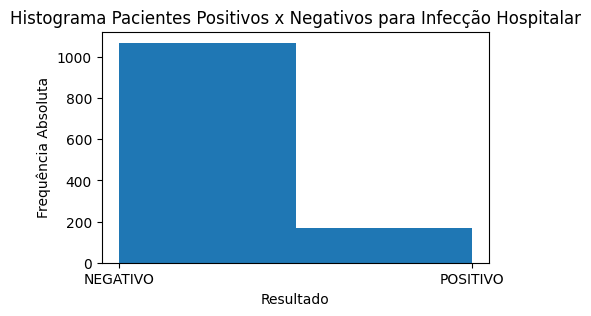


Lista pacientes com infecção:  (168, 2)
[Errno 2] No such file or directory: '/content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3'
/home/filipe/Documentos/GitHub/HCAI_prediction/DatasetConstruction


/home/filipe/.local/lib/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [44]:
df6 = df5.copy(deep=True)

def infec(x):
    '''
    Função para rotular exame Infecção(1) ou Não Infecção(0)
    '''
    #starting
    resultado = 0

    #Exame 1
    filtro_1 = ( x['Hemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais']=='POSITIVO')

    #Exame 2
    filtro_2 = ( x['Hemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais'] == 'POSITIVO')    

    #Exame 3
    filtro_3 = ( x['Hemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios'] == 'POSITIVO' )

    #Exame 4
    filtro_4 = ( x['Hemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios'] == 'POSITIVO' )

    #Exame 5
    filtro_5 = ( x['Fungos, Cultura.Fungos, Cultura'] == 'POSITIVO' )

    #Exame 6
    filtro_6 = ( x['Hemocultura, para Fungos, Varios Materiais.Hemocultura Fungos'] == 'POSITIVO' )

    # Guarantee it's a hospital infection
    filtro_7 = ( x['PERIODO'] >= 3)

    #condicional
    if ( (filtro_1 or filtro_2 or filtro_3 or filtro_4 or filtro_5 or filtro_6) and filtro_7 ):
        resultado = 1
    else:
        resultado = 0

    return resultado

# column creat
df6['INFEC'] = np.nan

# call covid()
df6['INFEC'] = df6.apply( lambda row : infec(row), axis = 1)

# grouping by PATIENT, as some patients had more than one exam
df_infec = df6.groupby( ['PACIENTE'] ).agg( { 'INFEC':['sum'] } ).reset_index()

# solving two-level columns problem
df_infec.columns = [ '_'.join(x) for x in df_infec.columns ]
df_infec.columns=['PACIENTE', 'INFEC']
#df_infec.to_excel('df_infec.xlsx')

# prints
print("Positivo: ")
print(df_infec[df_infec['INFEC']>=1].shape)
print('\nNegativo: ')
print(df_infec[df_infec['INFEC']==0].shape, '\n')

# Changing label from 1 to 'POSITIVE' and from 0 to 'NEGATIVE'
# out
def saida(x):
    #condicional
    if (x['INFEC']>0):
        resultado = 'POSITIVO'
    else:
        resultado = 'NEGATIVO'

    return resultado

# call saida()
df_infec['INFEC'] = df_infec.apply( lambda row : saida(row), axis = 1)

# Histogram
plt.title('Histograma Pacientes Positivos x Negativos para Infecção Hospitalar')
plt.xlabel('Resultado')
plt.ylabel('Frequência Absoluta')
plt.hist(df_infec['INFEC'], bins=2, rwidth=1.4)
plt.gcf().set_size_inches(5, 3) # alterar tamanho
plt.rcParams.update({'font.size': 10})
plt.show()

# Generates spreadsheet with positive patients
lista_infec_positivo = df_infec[df_infec['INFEC']=='POSITIVO']
print("\nLista pacientes com infecção: ", lista_infec_positivo.shape)
%cd /content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3
lista_infec_positivo.to_excel('lista_infec_positivo.xlsx')

In [45]:
df6

,PACIENTE,PERIODO,Amilase.183,Bilirrubinas Total E Fracoes.Bilirrubina Direta,Bilirrubinas Total E Fracoes.Bilirrubina Indireta,Bilirrubinas Total E Fracoes.Bilirrubina Total,"COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente MDRD",...,"Urina Tipo I - Jato Medio.Glicose, urina isol","Urina Tipo I - Jato Medio.Leucócitos, urina","Urina Tipo I - Jato Medio.Nitrito, urina","Urina Tipo I - Jato Medio.Proteínas, urina isolada","Urina Tipo I - Jato Medio.Urobilinogênio,urina","Urina Tipo I - Jato Medio.pH, urina","Urina, Cultura - Jato Médio.Cultura de Urina","Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial",Uréia.Uréia,INFEC
0,004688799FD293C3ABE0A07209FD8B75,0.0,76,"0,2","0,35","0,55",DETECTADO (POSITIVO),"2,26",28,32,...,"0,5",9000,negativa,"1,5","inferior a 1,0 mg/dL","6,0",NaN,NaN,86,0
1,004688799FD293C3ABE0A07209FD8B75,1.0,NaN,NaN,NaN,NaN,NaN,"2,11",36,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86,0
2,004688799FD293C3ABE0A07209FD8B75,2.0,NaN,NaN,NaN,NaN,NaN,"1,87",42,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,0
3,004688799FD293C3ABE0A07209FD8B75,3.0,NaN,NaN,NaN,NaN,NaN,"1,95",37,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106,0
4,004688799FD293C3ABE0A07209FD8B75,4.0,NaN,NaN,NaN,NaN,NaN,"1,86",41,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25056,FF4B2EED093AE641B9328FDB293C4116,7.0,NaN,NaN,NaN,NaN,NaN,"0,76",superior a 90,superior a 60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,0
25057,FF4B2EED093AE641B9328FDB293C4116,8.0,NaN,"0,17","0,15","0,32",NaN,"0,81",superior a 90,superior a 60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,0
25058,FF4B2EED093AE641B9328FDB293C4116,9.0,NaN,NaN,NaN,NaN,NaN,"0,89",superior a 90,superior a 60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"22,0",0
25059,FF4B2EED093AE641B9328FDB293C4116,10.0,NaN,NaN,NaN,NaN,NaN,"0,97",superior a 90,superior a 60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"20,0",0


In [46]:
ls

Covid_exploratory_analysis.ipynb  lista_covid_positivo.xlsx
Datasets_construction.ipynb       lista_infec_positivo.xlsx
exames_COVID19_considerados.xlsx  pacientes_negativos.xlsx
exames_COVID19_todos.xlsx         pacientes_positivos.xlsx
exames_infeccoes.xlsx


In [47]:
# Spreadsheet import
df_pacientes_positivos = pd.read_excel('lista_infec_positivo.xlsx', sheet_name='Sheet1')

# Datafram column to list
lista_pacientes = df_pacientes_positivos["PACIENTE"].values.tolist()
print("Lista pacientes positivos: ", len(lista_pacientes), "\n")

Lista pacientes positivos:  168 



In [48]:
# labeling patients as POSITIVE or NEGATIVE, for infection

def def_infec(x):
    #condicional
    if (x['PACIENTE'] in lista_pacientes):
        resultado = 'POSITIVO'
    else:
        resultado = 'NEGATIVO'

    return resultado

# call saida()
df6['INFEC'] = df6.apply( lambda row : def_infec(row), axis = 1)



## Adding outcome

In [49]:
inform_desfecho.columns = ['PACIENTE', 'DESFECHO']

inform_desfecho = inform_desfecho.groupby(['PACIENTE']).agg({'DESFECHO':['last']}).reset_index()

# solving two-levels problem
inform_desfecho.columns = [ '_'.join(x) for x in inform_desfecho.columns ]
inform_desfecho.columns=['PACIENTE', 'DESFECHO']

# Adds outcome for each patient
df_final = df6.merge(inform_desfecho, on=['PACIENTE'], how='left')

In [50]:
colunas = df_final.columns.to_list()
colunas

['PACIENTE',
 'PERIODO',
 'Amilase.183',
 'Bilirrubinas Total E Fracoes.Bilirrubina Direta',
 'Bilirrubinas Total E Fracoes.Bilirrubina Indireta',
 'Bilirrubinas Total E Fracoes.Bilirrubina Total',
 'COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente MDRD',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/não afrodescendente CKD-EPI',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/não afrodescendente MDRD',
 'Creatinina.Creatinina',
 'Creatinofosfoquinase Cpk-Ck.CK',
 'Cálcio Ionizável.Calcio Ionizavel',
 'D. Dimeros(Dimeros De Fibrina).Dimeros D, quant',
 'Desidrogenase Lática (DHL/L).DHL',
 'Desidrogenase Lática (DHL/L).DHL - IFCC',
 'Detecção de Coronaví

In [51]:
# changing the position of the 'INFEC' and 'OUTCOMES' column
colunas = ['PACIENTE',
 'PERIODO',
 'INFEC',
 'DESFECHO',
 'Bilirrubinas Total E Fracoes.Bilirrubina Direta',
 'Bilirrubinas Total E Fracoes.Bilirrubina Indireta',
 'Bilirrubinas Total E Fracoes.Bilirrubina Total',
 'COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente MDRD',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/não afrodescendente CKD-EPI',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/não afrodescendente MDRD',
 'Creatinina.Creatinina',
 'Creatinofosfoquinase Cpk-Ck.CK',
 'Cálcio Ionizável.Calcio Ionizavel',
 'D. Dimeros(Dimeros De Fibrina).Dimeros D, quant',
 'Desidrogenase Lática (DHL/L).DHL',
 'Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica).Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica)',
 'Ferritina, Dosagem.Ferritina',
 'Fibrinogênio, Dosagem Do.Fibrinogenio',
 'Fosfatase Alcalina.Fosfatase Alcalina',
 'Fungos, Cultura.Fungos, Cultura',
 'Fósforo.Fósforo',
 'Gama Gt.Gama-GT',
 'Gasometria Venosa.BE venoso',
 'Gasometria Venosa.HCO3 venoso',
 'Gasometria Venosa.Sat O2 venoso',
 'Gasometria Venosa.pCO2 venoso',
 'Gasometria Venosa.pH venoso',
 'Gasometria Venosa.pO2 venoso',
 'Glicemia, plasma.Glicose',
 'Hemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais',
 'Hemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais',
 'Hemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios',
 'Hemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios',
 'Hemocultura, para Fungos, Varios Materiais.Hemocultura Fungos',
 'Hemograma.Basófilos',
 'Hemograma.Basófilos (%)',
 'Hemograma.CHCM',
 'Hemograma.Eosinófilos',
 'Hemograma.Eosinófilos (%)',
 'Hemograma.Eritrócitos',
 'Hemograma.HCM',
 'Hemograma.Hematócrito',
 'Hemograma.Hemoglobina',
 'Hemograma.Leucócitos',
 'Hemograma.Linfócitos',
 'Hemograma.Linfócitos (%)',
 'Hemograma.Monócitos',
 'Hemograma.Monócitos (%)',
 'Hemograma.Morfologia, SB',
 'Hemograma.Morfologia, SVE',
 'Hemograma.Neutrófilos',
 'Hemograma.Neutrófilos (%)',
 'Hemograma.Plaquetas',
 'Hemograma.RDW',
 'Hemograma.VCM',
 'Hemograma.Volume plaquetário médio',
 'Lactato - Kit Urg.Lactato, sangue',
 'Lactato.Lactato, plasma',
 'Magnesio.Magnésio',
 'Peptideo Natriuretico Tipo B (Bnp).BNP',
 'Potássio.Potássio',
 'Proteína C Reativa, plasma.Proteína C-Reativa',
 'Pró-calcitonina, Dosagem no Plasma.Procalcitonina',
 'Sódio.Sódio',
 'Tempo E Ativid. Protrombina (Tp).TP/INR',
 'Tempo E Ativid. Protrombina (Tp).Tempo de Protrombina',
 'Tempo Tromb.Parcial Ativada.TTPA',
 'Tempo Tromb.Parcial Ativada.TTPA - Paciente/Normal',
 'Tempo Tromb.Parcial Ativada.TTPA-Normal do dia',
 'Tgo.AST (TGO)',
 'Tgp.ALT (TGP)',
 'Troponina.Troponina',
 'Tsh - Hormonio Tiroestimulante.TSH',
 'Urina Tipo I - Jato Medio.Aspecto, urina',
 'Urina Tipo I - Jato Medio.Bilirrubina,urina',
 'Urina Tipo I - Jato Medio.C.Cetônicos, urina',
 'Urina Tipo I - Jato Medio.Cilindros, urina',
 'Urina Tipo I - Jato Medio.Cor, urina',
 'Urina Tipo I - Jato Medio.Células Epiteliais',
 'Urina Tipo I - Jato Medio.Densidade, urina',
 'Urina Tipo I - Jato Medio.Eritrócitos, urina',
 'Urina Tipo I - Jato Medio.Glicose, urina isol',
 'Urina Tipo I - Jato Medio.Leucócitos, urina',
 'Urina Tipo I - Jato Medio.Nitrito, urina',
 'Urina Tipo I - Jato Medio.Proteínas, urina isolada',
 'Urina Tipo I - Jato Medio.Urobilinogênio,urina',
 'Urina Tipo I - Jato Medio.pH, urina',
 'Urina, Cultura - Jato Médio.Cultura de Urina',
 'Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial',
 'Uréia.Uréia']

In [52]:
df_final = df_final[colunas]

df_final.head(20)

,PACIENTE,PERIODO,INFEC,DESFECHO,Bilirrubinas Total E Fracoes.Bilirrubina Direta,Bilirrubinas Total E Fracoes.Bilirrubina Indireta,Bilirrubinas Total E Fracoes.Bilirrubina Total,"COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI",...,"Urina Tipo I - Jato Medio.Eritrócitos, urina","Urina Tipo I - Jato Medio.Glicose, urina isol","Urina Tipo I - Jato Medio.Leucócitos, urina","Urina Tipo I - Jato Medio.Nitrito, urina","Urina Tipo I - Jato Medio.Proteínas, urina isolada","Urina Tipo I - Jato Medio.Urobilinogênio,urina","Urina Tipo I - Jato Medio.pH, urina","Urina, Cultura - Jato Médio.Cultura de Urina","Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial",Uréia.Uréia
0,004688799FD293C3ABE0A07209FD8B75,0.0,NEGATIVO,Alta médica melhorado,"0,2","0,35","0,55",DETECTADO (POSITIVO),"2,26",28,...,11000,"0,5",9000,negativa,"1,5","inferior a 1,0 mg/dL","6,0",NaN,NaN,86
1,004688799FD293C3ABE0A07209FD8B75,1.0,NEGATIVO,Alta médica melhorado,NaN,NaN,NaN,NaN,"2,11",36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86
2,004688799FD293C3ABE0A07209FD8B75,2.0,NEGATIVO,Alta médica melhorado,NaN,NaN,NaN,NaN,"1,87",42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92
3,004688799FD293C3ABE0A07209FD8B75,3.0,NEGATIVO,Alta médica melhorado,NaN,NaN,NaN,NaN,"1,95",37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106
4,004688799FD293C3ABE0A07209FD8B75,4.0,NEGATIVO,Alta médica melhorado,NaN,NaN,NaN,NaN,"1,86",41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97
5,004688799FD293C3ABE0A07209FD8B75,5.0,NEGATIVO,Alta médica melhorado,NaN,NaN,NaN,NaN,"2,02",38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
6,004688799FD293C3ABE0A07209FD8B75,6.0,NEGATIVO,Alta médica melhorado,NaN,NaN,NaN,NaN,"2,18",35,...,3000,"inferior a 0,3 g/L",5000,negativa,"0,28","inferior a 1,0 mg/dL","5,0",NEGATIVO,Parcial Negativo,108
7,004688799FD293C3ABE0A07209FD8B75,7.0,NEGATIVO,Alta médica melhorado,NaN,NaN,NaN,NaN,"2,38",31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135
8,004688799FD293C3ABE0A07209FD8B75,8.0,NEGATIVO,Alta médica melhorado,NaN,NaN,NaN,NaN,"2,11",36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116
9,004688799FD293C3ABE0A07209FD8B75,9.0,NEGATIVO,Alta médica melhorado,NaN,NaN,NaN,NaN,"2,13",36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110


In [53]:
df_infec_positivo = df_final[df6["INFEC"]=='POSITIVO']

df_infec_positivo["PACIENTE"].nunique()

168

In [136]:
#df_final.to_excel('resultados_geral.xlsx')
#df_infec_positivo.to_excel('resultados_somente_positivos.xlsx')

## Checking outcome of positive patients

In [54]:
df_infec_positivo.head(3)

,PACIENTE,PERIODO,INFEC,DESFECHO,Bilirrubinas Total E Fracoes.Bilirrubina Direta,Bilirrubinas Total E Fracoes.Bilirrubina Indireta,Bilirrubinas Total E Fracoes.Bilirrubina Total,"COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI",...,"Urina Tipo I - Jato Medio.Eritrócitos, urina","Urina Tipo I - Jato Medio.Glicose, urina isol","Urina Tipo I - Jato Medio.Leucócitos, urina","Urina Tipo I - Jato Medio.Nitrito, urina","Urina Tipo I - Jato Medio.Proteínas, urina isolada","Urina Tipo I - Jato Medio.Urobilinogênio,urina","Urina Tipo I - Jato Medio.pH, urina","Urina, Cultura - Jato Médio.Cultura de Urina","Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial",Uréia.Uréia
169,028D6E2C0A51B4E2D3B919DB94D6BCB2,0.0,POSITIVO,Alta médica melhorado,"0,07","0,03","0,1",NaN,"0,9",89,...,2000,"inferior a 0,3 g/L",1000,negativa,"inferior a 0,10 g/L","inferior a 1,0 mg/dL","7,0",NEGATIVO,Parcial Negativo,36
170,028D6E2C0A51B4E2D3B919DB94D6BCB2,1.0,POSITIVO,Alta médica melhorado,NaN,NaN,NaN,NaN,"0,94",78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59
171,028D6E2C0A51B4E2D3B919DB94D6BCB2,2.0,POSITIVO,Alta médica melhorado,NaN,NaN,NaN,NaN,"0,6",superior a 90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36


In [55]:
df_grupos = df_infec_positivo[["PACIENTE", "DESFECHO"]]

grupos = df_grupos.groupby(["PACIENTE"]).agg( {"DESFECHO" :['last']}).reset_index()

#solucionando nome colunas dois niveis
grupos.columns = [ '_'.join(x) for x in grupos.columns ]
grupos.columns=['PACIENTE', 'DESFECHO']

grupos["DESFECHO"].value_counts()

# número de óbitos = 15 em 39

DESFECHO
Alta médica melhorado                                               108
Óbito após 48hs de internação sem necrópsia                          39
Alta médica curado                                                    8
Óbito nas primeiras 48hs de internação sem necrópsia não agônico      6
Alta Administrativa                                                   2
Transferência Inter-Hospitalar Externa - Serviço de Ambulância        2
Alta por abandono                                                     1
Transferência Inter-Hospitalar Externa - Transporte Próprio           1
Óbito nas primeiras 48hs de internação sem necrópsia agônico          1
Name: count, dtype: int64

## Generating list of positive patients

In [56]:
grupos.shape

(168, 2)

In [59]:
pacientes_positivos = grupos["PACIENTE"]

print(pacientes_positivos.shape)

pacientes_positivos.to_excel("pacientes_positivos.xlsx")

(168,)


## Generating list of negative patients

In [60]:
pacientes_negativos = df_final[df_final["INFEC"]=="NEGATIVO"]

pacientes_negativos = pacientes_negativos["PACIENTE"].unique()

pacientes_negativos.shape

(1069,)

In [61]:
pacientes_negativos = pd.DataFrame(pacientes_negativos)

pacientes_negativos.to_excel("pacientes_negativos.xlsx")

# THE END OF DATASET CONSTRUCTION